# Bulldozer Sale Price Prediction

This notebook is based on the notebook  _["end-to-end-bluebook-bulldozer-price-regressor.ipynb"](https://github.com/mrdbourke/zero-to-mastery-ml/tree/wip/section-3-structured-data-projects)_ from the Udemy course _"Complete ML & Data Science Bootcamp 2023."_ The same framework, dataset and evaluation metrics will be used but we will be using the following models:  
* RandomForestRegressor
* HistGradientBoostingRegressor  
* GradientBoostingRegressor  
* LSTM
* StackingRegressor
* CatBoost  

There will be 6 experiments, the first 3 will use RandomSearchCV to find the best hyperparameters for the models RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor. The next expirement will be training an LSTM model. The fourth experiment will use the best resulting models of each of the previous experiments in the StackingRegressor to see if we get better results. And the last experiment will use CatBoost. By the end of this we would have come up with a higher preforming model in predicting future bulldozer prices.    

## 1. Problem Definition

This notebook is set to solve a couple problems.  
1. We would like to create a model that can predict future bulldozer prices based on historical data.  
2. We would like to create a better performing model than the one used in the course.  

## 2. Data

The same dataset from [Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data) will be used. There are three files:  
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).  
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).  
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).  

## 3. Evaluation

The Kaggle competetion required the use of RMSLE (Root Mean Square Log Error), As well as R^2 and MAE (Mean Absolute Error).

## 4. Features  


Kaggle has provide a [data dictionary](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) which contains information about what each feature of the dataset means, of which there are 102.

## 5. Experiments
The code starts here.

For each experiment there will be a section that fits the model from scratch and a section that loads a saved Model. If this is the first time running the notebook, please run the fitting section otherwise, just run the saved models section to get the scores and predictions.

In [2]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-10-07 16:03:01.394409


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Packages

In [2]:
import sys
import os
import datetime
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Display plots in the notebook
%matplotlib inline
%load_ext tensorboard

# Import Model tools
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
#!pip install keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Import Evaluation Tools
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

# Install and Import CatBoost
#!pip install catboost
#from catboost import CatBoostRegressor

FilePath = "/content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/"
CheckpointPath = "/content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/Models/Checkpoints/"
BATCH_SIZE = 32

### Importing Data

In [ ]:
# Importing the Train and Validate set to split the dataset ourselves
FilePath = "/content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/"
df = pd.read_csv(FilePath+"data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])
df_test = pd.read_csv(FilePath+"data/Test.csv", low_memory=False, parse_dates=["saledate"])

#### Data Exploration

In [ ]:
df.info()

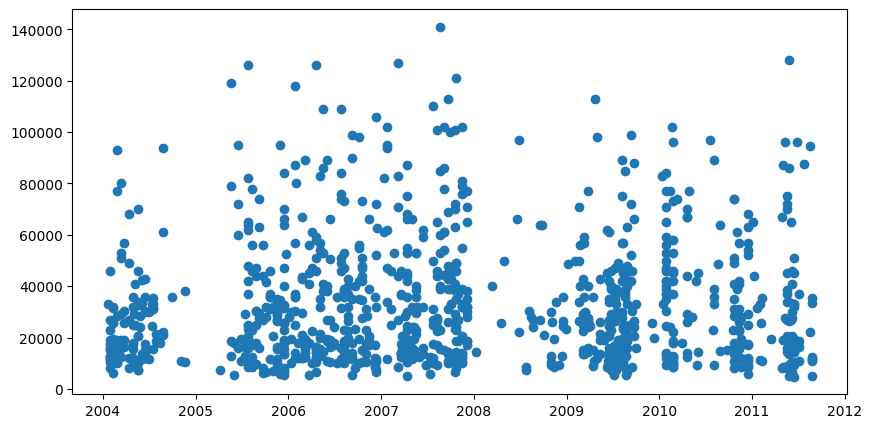

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

### Data Pre-Processing
Start preprocessing the data by making a copy of the dataset to work with.

In [ ]:
# Sort the data by Sale Date
df.sort_values(by=["saledate"], inplace=True, ascending=True)
# Making a copy of the data frame
df_tmp = df.copy()

In [ ]:
# Add datetime parameters for saledate
if "saledate" in df_tmp.columns:
    df_tmp["saleYear"] = df_tmp.saledate.dt.year
    df_tmp["saleMonth"] = df_tmp.saledate.dt.month
    df_tmp["saleDay"] = df_tmp.saledate.dt.day
    df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
    df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

    # Drop original saledate
    df_tmp.drop("saledate", axis=1, inplace=True)

df_tmp.head().T

In [ ]:
## Check the different values of different columns
df_tmp.state.value_counts()
#df_tmp.MachineHoursCurrentMeter.value_counts()

In [ ]:
df_tmp.Grouser_Type.dtype

In [ ]:
## Check for NaN values
df_tmp.isna().sum()

#### Filling Categorical Data

In [ ]:
# List columns that contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content) or pd.api.types.is_object_dtype(content):
        print(label)

In [ ]:
# For each column that contains a string, convert to Category
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content) or pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

df_tmp.info()

In [ ]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1

#### Splitting Data Set
Must split the data before filling in numerical data.

In [ ]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

#### Filling Numerical Data

In [ ]:
# Fill numeric NaN data with the median for Validate data set
for label, content in df_val.items():

    if pd.api.types.is_numeric_dtype(content):

        if pd.isnull(content).sum():
            #print("Has NA: ", label)
            # Add a binary col to identify the previously missing data
            df_val[label+"_is_missing"] = pd.isnull(content)
            # Fill with median
            df_val[label] = content.fillna(content.median())

# Fill numeric NaN data with the median for Training data set
for label, content in df_train.items():

    if pd.api.types.is_numeric_dtype(content):

        if pd.isnull(content).sum():
            #print("Has NA: ", label)
            # Add a binary col to identify the previously missing data
            df_train[label+"_is_missing"] = pd.isnull(content)
            # Fill with median
            df_train[label] = content.fillna(content.median())

In [ ]:
df_train.isna().sum()

### Reload Saved Data

In [3]:
# Save preprocessed data and load it if applicable
def save_and_load_data(validationData, trainingData):
  """ Save and return the validation and training datasets.
  If the data has already been processed and saved, this function will load the data and return it.
  If the data has not been processed and saved, this function will save it and return the input variables.
  """
  if "valid_tmp.csv" not in os.listdir(FilePath+"data/") or validationData != None:
    validationData.to_csv(FilePath+"data/valid_tmp.csv",
                index=False)
    df_val = validationData
  else:
    df_val = pd.read_csv(FilePath+"data/valid_tmp.csv")

  if "train_tmp.csv" not in os.listdir(FilePath+"data/") or trainingData != None:
    trainingData.to_csv(FilePath+"data/train_tmp.csv",
                index=False)
    df_train = trainingData
  else:
    df_train = pd.read_csv(FilePath+"data/train_tmp.csv")

  return df_val, df_train

df_val, df_train = save_and_load_data(None, None)

### Experimentation

In [18]:
# Create the train validate data sets
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [6]:
# Compare sets to find missing column
set(X_train.columns) - set(X_valid.columns)

set()

In [ ]:
# Add missing column to Validate dataset
df_val["auctioneerID_is_missing"] = False
X_valid["auctioneerID_is_missing"] = False

#### Create Evaluation Fuction

In [19]:
# Create Root Mean Square Log Error func
def rmsle(y_test, y_preds):
    msle = mean_squared_log_error(y_test, y_preds)
    print(msle)
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create func to evaluate any model where results is DF compatible
def get_scores(model, X_train, X_valid, y_train, y_valid, modelName, Scores=None):
    if Scores == None:
        Scores = {"cols": ["Model", "Training MAE", "Valid MAE",
                           "Valid RMSLE", "Training R^2", "Valid R^2", "Valid MSE","Valid RMSE"],
                  "data": []}
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    val_rmsle = None
    val_rmse = None

    try:
      val_rmsle = rmsle(y_train, train_preds)
    except Exception as e:
      print(e)
      val_rmsle = None

    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_valid, val_preds)
    train_score = r2_score(train_preds, y_train)
    val_score = r2_score(val_preds, y_valid)
    val_mse = mean_squared_error(y_valid, val_preds)

    try:
      val_rmse = np.sqrt(val_mse)
    except Exception as e:
      print(e)
      val_rmse = None

    if modelName in Scores["data"]:
      Scores["data"][modelName] = [modelName,
                      train_mae, val_mae,
                      val_rmsle,
                      train_score, val_score,
                      val_mse,
                      val_rmse]
    else:
        Scores["data"].append([modelName,
                      train_mae, val_mae,
                      val_rmsle,
                      train_score, val_score,
                      val_mse,
                      val_rmse])

    return Scores

def get_saved_scores():
  return pd.read_csv(FilePath+"prelim_scores.csv")

#### EXP 1: Fitting Original Model - RandomForestRegressor

##### Using Random Search to find best params

In [ ]:
%%time
np.random.seed(1995)

# Set Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": [10, 30, 50, 90],
           "max_depth": [None, 1, 2, 3],
           "min_samples_split": [2, 4, 6],
           "min_samples_leaf": [1, 2, 3, 4],
           "max_features": [0.5, 1.0, "sqrt"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=250,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

# Save Model
filename = FilePath + "Models/rs-model-rfr.sav"
joblib.dump(rs_model, filename)

In [ ]:
# Print the best hyperparameters and score
print(rs_model.best_params_)
print(rs_model.score(X_train, y_train))

{'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 10000, 'max_features': 1.0, 'max_depth': None}
0.861360395348496


###### Loading Saved Model
Load the saved model if the previous block was run.

In [ ]:
## Load Model if it has been saved
## Note: Only run this block if the previous block has been run already
filename = FilePath + "Models/rs-model-rfr.sav"
rs_model = joblib.load(filename)
print(rs_model.best_params_)
print(rs_model.score(X_train, y_train))

**Best Run when `niter = 100`:**  
Wall time: 35min  
Params: `{'n_estimators': 90, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_samples': 10000, 'max_features': 1.0, 'max_depth': None}`  
Score: 0.8468122285819087  

  
**Best Run when `niter = 250`:**  
Wall time: 47min 46s  
Params: `{'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 10000, 'max_features': 1.0, 'max_depth': None}`  
Score: 0.861360395348496

##### Fit Model with Best Hyperparams

In [ ]:
# Run Best Params
# Run this cell only if the previous cells have been run
#%%time
np.random.seed(1995)
model_rfr = RandomForestRegressor(n_estimators=90, min_samples_split=2, min_samples_leaf=1, max_samples=10000, max_features=1.0, max_depth=None)
model_rfr.fit(X_train, y_train)

# Save Model
filename = FilePath + "Models/rfr-model.sav"
joblib.dump(model_rfr, filename)

['/content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/Models/rfr-model.sav']

In [20]:
## Load Model if it has been saved
## Note: Only run this block if the previous block has been run already
filename = FilePath + "Models/rfr-model.sav"
model_rfr = joblib.load(filename)
print(model_rfr.score(X_train, y_train))

0.8609609862620538


##### Scoring using the best params

In [21]:
#%%time
np.random.seed(1995)
cols = X_train.columns
X_valid = X_valid.reindex(columns=cols)

score_res = get_scores(model_rfr, X_train, X_valid, y_train, y_valid, "RandomForestRegressor", None)
print(score_res)

0.06651461400435313
{'cols': ['Model', 'Training MAE', 'Valid MAE', 'Valid RMSLE', 'Training R^2', 'Valid R^2', 'Valid MSE', 'Valid RMSE'], 'data': [['RandomForestRegressor', 5555.081538229284, 7130.010130860144, 0.2579042729470629, 0.8207015984964349, 0.7691442151102865, 113700642.48573755, 10663.05033682846]]}


In [22]:
df_scores = pd.DataFrame(score_res["data"], columns=score_res["cols"]).set_index("Model")
df_scores

,Training MAE,Valid MAE,Valid RMSLE,Training R^2,Valid R^2,Valid MSE,Valid RMSE
Model,,,,,,,
RandomForestRegressor,5555.081538,7130.010131,0.257904,0.820702,0.769144,1.137006e+08,10663.050337


#### EXP 2: Fitting New Model - HistGradientBoostingRegressor

##### Using Random Search to find best params

In [ ]:
%%time
np.random.seed(1995)

# Set Different HistGradientBoostingRegressor hyperparameters
rf_grid_HGBR = {"loss": ["squared_error", "absolute_error", "gamma", "poisson", "quantile"],
                "max_leaf_nodes": [31, None, 50, 100],
                "learning_rate": [0.1, 0.05, 0.2],
                "max_depth": [None, 1, 2, 3],
                "max_iter": [100, 200]}

rs_model_HGBR = RandomizedSearchCV(HistGradientBoostingRegressor(),
                              param_distributions=rf_grid_HGBR,
                              n_iter=50,
                              cv=5,
                              verbose=True)

rs_model_HGBR.fit(X_train, y_train)

# Save Model
filename = FilePath + "Models/rs-model-hgbr.sav"
joblib.dump(rs_model_HGBR, filename)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/rsbaher/anaconda3/envs/bulldozer-prices-ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
70 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rsbaher/anaconda3/envs/bulldozer-prices-ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rsbaher/anaconda3/envs/bulldozer-prices-ml/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/rsbaher/anaconda3/envs/bulldozer-prices-ml/lib/py

CPU times: user 11h 40min 11s, sys: 4min 46s, total: 11h 44min 58s
Wall time: 1h 34min 24s


RandomizedSearchCV(cv=5, estimator=HistGradientBoostingRegressor(), n_iter=50,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.2],
                                        'loss': ['squared_error',
                                                 'absolute_error', 'gamma',
                                                 'poisson', 'quantile'],
                                        'max_depth': [None, 1, 2, 3],
                                        'max_iter': [100, 200],
                                        'max_leaf_nodes': [31, None, 50, 100]},
                   verbose=True)

In [ ]:
## Load Model if it has been saved
## Note: Only run this block if the previous block has been run already
filename = FilePath + "Models/rs-hgbr-model.sav"
rs_model_HGBR = joblib.load(filename)
print(rs_model_HGBR.best_params_)
print(rs_model_HGBR.score(X_train, y_train))

In [ ]:
rs_model_HGBR.best_params_

{'max_leaf_nodes': None,
 'max_iter': 100,
 'max_depth': None,
 'loss': 'poisson',
 'learning_rate': 0.05}

##### Fit Model with Best Hyperparams

In [ ]:
%%time
np.random.seed(1995)

model_HBR = HistGradientBoostingRegressor(max_leaf_nodes=None, max_iter=100, max_depth=None, loss='poisson', learning_rate=0.05)
model_HBR.fit(X_train, y_train)

# Save Model
filename = FilePath + "Models/model-hgbr.sav"
joblib.dump(model_HBR, filename)

CPU times: user 15min 37s, sys: 19.2 s, total: 15min 57s
Wall time: 10min 1s


['/content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/Models/model-hgbr.sav']

In [23]:
## Load Model if it has been saved
## Note: Only run this block if the previous block has been run already
filename = FilePath + "Models/model-hgbr.sav"
model_HBR = joblib.load(filename)
print(model_HBR.score(X_train, y_train))

0.974541895554902


##### Scoring using the best params

Best Params:  
{'max_leaf_nodes': None,
 'max_iter': 100,
 'max_depth': None,
 'loss': 'poisson',
 'learning_rate': 0.05}

 Score: 0.877257971650657  

In [24]:
score_res = get_scores(model_HBR, X_train, X_valid, y_train, y_valid, "HistGradientBoostingRegressor", score_res)
print(score_res)

0.01569802186197478
{'cols': ['Model', 'Training MAE', 'Valid MAE', 'Valid RMSLE', 'Training R^2', 'Valid R^2', 'Valid MSE', 'Valid RMSE'], 'data': [['RandomForestRegressor', 5555.081538229284, 7130.010130860144, 0.2579042729470629, 0.8207015984964349, 0.7691442151102865, 113700642.48573755, 10663.05033682846], ['HistGradientBoostingRegressor', 2254.3807695660184, 5973.091776662905, 0.12529174698269147, 0.9726169824140402, 0.8528221226127716, 84815279.94017413, 9209.521156942641]]}


In [25]:
df_scores = pd.DataFrame(score_res["data"], columns=score_res["cols"]).set_index("Model")
#df_scores.to_csv(FilePath+"prelim_scores.csv") 0.876520
df_scores

,Training MAE,Valid MAE,Valid RMSLE,Training R^2,Valid R^2,Valid MSE,Valid RMSE
Model,,,,,,,
RandomForestRegressor,5555.081538,7130.010131,0.257904,0.820702,0.769144,1.137006e+08,10663.050337
HistGradientBoostingRegressor,2254.380770,5973.091777,0.125292,0.972617,0.852822,8.481528e+07,9209.521157


#### EXP 3: Fitting New Model - LSTM

##### LSTM Functions

In [5]:
# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, data_type='train'):
  """
  Creates batches of data out of input (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  data_batch = []
  # If the data is a test dataset, we probably don't have labels
  if data_type == 'test':
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.batch(BATCH_SIZE)


  # If the data if a valid dataset, we don't need to shuffle it
  elif  data_type == 'valid':
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.batch(BATCH_SIZE)


  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    const_x = tf.constant(np.asarray(x))
    const_y = tf.constant(np.asarray(y))
    data = tf.data.Dataset.from_tensor_slices((const_x, # filepaths
                                              const_y)) # labels

    # Shuffling Data
    data = data.shuffle(buffer_size=len(x))

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

## Reshape
#X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
#X_valid_lstm = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

# List columns that contain strings
for label, content in X_train.items():
    if pd.api.types.is_bool_dtype(content):
        X_train[label] = X_train[label].astype('float')

# List columns that contain strings
for label, content in X_valid.items():
    if pd.api.types.is_bool_dtype(content):
        X_valid[label] = X_valid[label].astype('float')

def create_tb_callback():
  logdir = os.path.join(FilePath,"Models/lstmLogs/",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

def create_save_callback():
  lstm_ckpt_path = CheckpointPath+"lstm-{epoch:04d}.ckpt"
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=lstm_ckpt_path,
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
    )

def unbatch_ds(ds):
  ds_unbatched = ds.unbatch()
  X = list(ds_unbatched.map(lambda x, y: x))
  Y = list(ds_unbatched.map(lambda x, y: y))
  return X, Y

##### Batching Data

In [6]:
X_train_lstm = create_data_batches(X_train, y_train, data_type='train')
X_valid_lstm = create_data_batches(X_valid, y_valid, data_type='valid')
X_train.shape, X_train_lstm, X_valid_lstm

Creating training data batches...
Creating validation data batches...


((401125, 102),
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 102), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 102), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

##### Build and Train Model

In [7]:
## Build LSTM model
model_lstm = Sequential()
lstm_1 = LSTM(units=X_train.shape[1], return_sequences=True, input_shape=(X_train.shape[1], 1))
lstm_2 = LSTM(units=64, return_sequences=True)

model_lstm.add(lstm_1)
model_lstm.add(lstm_2)
model_lstm.add(Dense(units=1))

# Create Model Callbacks
model_checkpoint_cb = create_save_callback()
model_tb_cb = create_tb_callback()

## Compile and Train model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Load existing weights if any
if os.listdir(CheckpointPath):
  latest = tf.train.latest_checkpoint(CheckpointPath)
  model_lstm.load_weights(latest)

In [14]:
# Start Training
model_lstm.fit(X_train_lstm, epochs=10, batch_size=32, verbose=1,
               callbacks=[model_checkpoint_cb, model_tb_cb])


Epoch 1/10
12536/12536 [==============================] - ETA: 0s - loss: 531226816.0000
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/Models/Checkpoints/lstm-0001.ckpt
12536/12536 [==============================] - 149s 12ms/step - loss: 531226816.0000
Epoch 2/10
12535/12536 [============================>.] - ETA: 0s - loss: 531228768.0000
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/Models/Checkpoints/lstm-0002.ckpt
12536/12536 [==============================] - 145s 11ms/step - loss: 531225984.0000
Epoch 3/10
12531/12536 [============================>.] - ETA: 0s - loss: 531162528.0000
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/Models/Checkpoints/lstm-0003.ckpt
12536/12536 [==============================] - 143s 11ms/step - loss: 531227488.0000
Epoch 4/10
12534/12536 [============================>.] - ETA: 0s - loss: 531223072.0000
Epoch 4: saving model t

##### Scoring Model

After 250 epochs of training, the results are still not great, so we will be abondoning this model.

#### EXP 4: Fitting New Model - StackingRegressor

##### Fitting Model

In [ ]:
%%time
np.random.seed(1995)

estimators = [("rfr", RandomForestRegressor()),
              ("rfr-tuned", RandomForestRegressor(n_estimators=90, min_samples_split=2, min_samples_leaf=1, max_samples=10000, max_features=1.0, max_depth=None))]
final_est = HistGradientBoostingRegressor(max_leaf_nodes=None, max_iter=100, max_depth=None, loss='poisson', learning_rate=0.05)

model_stack = StackingRegressor(estimators=estimators, final_estimator=final_est)

model_stack.fit(X_train, y_train)

# Save Model
filename = FilePath + "Models/model-stack.sav"
joblib.dump(model_stack, filename)

CPU times: user 1h 2min 31s, sys: 17.4 s, total: 1h 2min 48s
Wall time: 1h 2min 22s


['/content/drive/MyDrive/Colab Notebooks/BulldozerPricePredictor/Models/model-stack.sav']

In [26]:
## Load Model if it has been saved
## Note: Only run this block if the previous block has been run already
filename = FilePath + "Models/model-stack.sav"
model_stack = joblib.load(filename)
print(model_stack.score(X_train, y_train))

0.9591390217003545


##### Scoring Model

In [27]:
score_res = get_scores(model_stack, X_train, X_valid, y_train, y_valid, "StackingRegressor", score_res)
print(score_res)

0.018820990119962407
{'cols': ['Model', 'Training MAE', 'Valid MAE', 'Valid RMSLE', 'Training R^2', 'Valid R^2', 'Valid MSE', 'Valid RMSE'], 'data': [['RandomForestRegressor', 5555.081538229284, 7130.010130860144, 0.2579042729470629, 0.8207015984964349, 0.7691442151102865, 113700642.48573755, 10663.05033682846], ['HistGradientBoostingRegressor', 2254.3807695660184, 5973.091776662905, 0.12529174698269147, 0.9726169824140402, 0.8528221226127716, 84815279.94017413, 9209.521156942641], ['StackingRegressor', 2952.391601039184, 6466.718453500353, 0.13718961374667693, 0.9533920365985926, 0.8291382331073638, 93229043.08842742, 9655.518789191361]]}


In [28]:
df_scores = pd.DataFrame(score_res["data"], columns=score_res["cols"]).set_index("Model")
df_scores.to_csv(FilePath+"prelim_scores.csv")
df_scores

,Training MAE,Valid MAE,Valid RMSLE,Training R^2,Valid R^2,Valid MSE,Valid RMSE
Model,,,,,,,
RandomForestRegressor,5555.081538,7130.010131,0.257904,0.820702,0.769144,1.137006e+08,10663.050337
HistGradientBoostingRegressor,2254.380770,5973.091777,0.125292,0.972617,0.852822,8.481528e+07,9209.521157
StackingRegressor,2952.391601,6466.718454,0.137190,0.953392,0.829138,9.322904e+07,9655.518789


## Final Results

In [30]:
## Load Scores
pd_scores = get_saved_scores()
pd_scores

,Model,Training MAE,Valid MAE,Valid RMSLE,Training R^2,Valid R^2,Valid MSE,Valid RMSE
0,RandomForestRegressor,5555.081538,7130.010131,0.257904,0.820702,0.769144,1.137006e+08,10663.050337
1,HistGradientBoostingRegressor,2254.380770,5973.091777,0.125292,0.972617,0.852822,8.481528e+07,9209.521157
2,StackingRegressor,2952.391601,6466.718454,0.137190,0.953392,0.829138,9.322904e+07,9655.518789


The results show that the best performing Model is the **HistGradientBoostingRegressor** with an R^2 Score of *85.28%*  
It also has the lowest MAE, MSE, and RMSE.
